<a href="https://colab.research.google.com/github/nayoung718/essa_python_1/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C_ch7_6_pg_452~465.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#파이썬 머신러닝 완벽가이드 ch7. 6 pg. 452 ~ 465

06. 군집화 실습 - 고객 세그먼테이션

-고객 세그먼테이션: 다양한 기준으로 고객 분류 기법

-> 보통 상품 판매 중점: 어떤 상품을 얼마나 많은 비용써서 얼마나 자주 사용하는가 기반-> 타깃 마케팅 (고객을 여러 특성에 맞게 세분화해 그 유형에 따라 맞춤형 마케팅이나 서비스 제공) -> 고객 상품 구매 이력에서 출발

-고객 군집화 중요: RFM 기법 이용: Recency, Frequency, Monetary value

-데이터 세트 로딩과 데이터 클렌징



In [14]:
import numpy as np
import datetime
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

retail_df = pd.read_excel('/Online Retail.xlsx')
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [15]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [16]:
#null 데이터 제거, 오류 데이터 삭제
retail_df = retail_df[retail_df['Quantity']>0]
retail_df = retail_df[retail_df['UnitPrice']>0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape) # shape 출력
print(retail_df.isnull().sum()) # 결측값 개수 확인

(397884, 8)
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [17]:
retail_df['Country'].value_counts()[:5]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

In [18]:
#영국이 대다수이므로 다른 국가 데이터 제외함
retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


RFM 기반 데이터 가공

- UnitPrice와 Quantity 곱해서 주문 금액 데이터 만들어, CustomerNo int형으로 변경

In [19]:
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [20]:
#TOP-5 주문 건수, 주문 금액 데이터 추출
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False).head(5))

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


In [21]:
#InvoiceNo, StockCode 로 1에 가깝게 유일한 식별자 레벨
retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

In [22]:
#RFM기반 고객 세그멘테이션: 고객레벨로 주문기간, 주문횟수, 주문금액 데이터를 기반으로해 세그멘테이션 수행
#주문번호+상품코드 기준 데이터를 고객 기준 recency, frequency, monetary value 데이터로 변경-> 주문번호 기분 데이터를 개별고객 기준 데이터로 groupby

#DataFrame의 groupby()의 multiple 연산을 위해 agg()을 이용
#Recency는 InvoiceDate 칼럼의 max()에서 데이터 가공
#Frequency는 InvoiceDate 칼럼의 count(), Monetary value 는 sale_amount 칼럼의 sum()
aggregations = {
    'InvoiceDate':'max',
    'InvoiceNo':'count',
    'sale_amount':'sum'
}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
#groupby된 결과 칼럼 값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency',
                                   'InvoiceNo':'Frequency',
                                   'sale_amount':'Monetary'
                                   }
                        )
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


In [23]:
#Recency = 오늘 날짜 - 최근 주문 날짜 로 변경하여 데이터 가공

import numpy as np

cust_df['Recency'] = datetime.datetime(2011, 12, 10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x : x.days+1)
print('cust_df 로우와 칼럼의 건수는', cust_df.shape)
cust_df

cust_df 로우와 칼럼의 건수는 (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73
3,12749,4,199,4090.88
4,12820,4,59,942.34
...,...,...,...,...
3915,18280,278,10,180.60
3916,18281,181,7,80.82
3917,18282,8,12,178.05
3918,18283,4,756,2094.88


-RFM 기반 고객 세그먼테이션

온라인 판매 데이터셋의 칼럼별 히스토그램 확인, 왜곡된 데이터 분포도서 군집화 수행시 어떤 현상 발생하는지 알아보자

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <BarContainer object of 10 artists>)

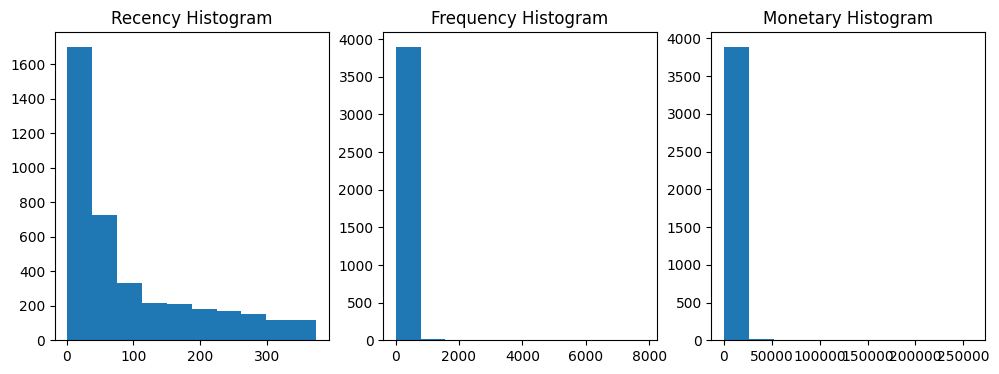

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

In [25]:
#왜곡된 데이터 값-> 데이터값 백분위로 대략적 어떤값 분포돼있는지 확인
cust_df[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


In [26]:
#StandScaler로 평균과 표준편차 재조정
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency', 'Frequency', 'Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

#K-평균 수행
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


실루엣 스코어는 : 0.592


In [31]:
#군집별 실루엣 계수값 확인
#visualize_silhouette([2,3,4,5], X_features_scaled)
#visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

In [32]:
#데이터의 왜곡 정도를 낮추기 위해 로그 변환

#Recency, Frequency, Monetary 칼럼에 np.log1p()로 Log Transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

#Log Transformation 데이터에 StandScaler 적용
X_features = cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']]#.values
X_features_scaled = StandardScaler().fit_transform(X_features)

#K-평균 수행
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


실루엣 스코어는 : 0.303


실루엣 스코어는 로그 변환 전보다 떨어짐-> 실루엣스코어의 절대치가 중요한 것은 아님, 어떻게 개별 군집이 더 균일하게 나뉠 수 있는지가 더 중요

08 텍스트 분석

nlp냐 텍스트 분석이냐?

nlp는 언어를 해석하기 위한 기계 번역, 자동으로 질문을 해석하고 답 해주는 질의응답 시스템 등의 영역에서 텍스트 분석과 차별점 있음, 텍스트 분석은 머신러닝, 언어 이해, 통계 활용해 모델 수립후 정보 추출해 bi 나 예측 분석 등 분석 작업 주로 수행